## Traininig of the High Level Feature classifier with TensorFlow/Keras and Petastorm

**4.0 Tensorflow/Keras and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Data is read using the Petastorm library.
Note, Spark is not used in this case.

The High-Level Features classifier is built with labeled data
 - input: 14 features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
![Physics use case for the particle classifier](../Docs/Physics_use_case.png)

To run this notebook we used the following configuration:
* *Software stack*: 
* TensorFlow 2.11
* Petastorm 0.12
* *Platform*: CentOS 7, Python 3.9


## Create the Keras model

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

tf.version.VERSION

'2.11.0'

In [2]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [4]:
# define the Keras model
keras_model = create_model(50, 20, 10)

2023-03-14 10:56:39.705547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 10:56:40.169725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3038 MB memory:  -> device: 0, name: Quadro K2200, pci bus id: 0000:02:00.0, compute capability: 5.0


## Load data and train the Keras model

In [6]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "file:///eos/project/s/sparkdltrigger/public/"

file_train_dataset = PATH + "trainUndersampled_HLF_features.parquet"
file_test_dataset = PATH + "testUndersampled_HLF_features.parquet"

# PATH needs to be prefixed by the fileystem type as in:
# "file://<full_path>_on_filesystem/Parquet_folder/"
# "hdfs://<full_path_on_hdfs>/Parquet_folder/"


In [7]:
# We use the petastorm libary to load and feed the training and test data in Parquet format
# It makes use TensorFLow tf.data.dataset

import petastorm
from petastorm import make_batch_reader
from petastorm.tf_utils import make_petastorm_dataset

petastorm.__version__

'0.12.1'

In [8]:
#
# Train with TensorFlow using Petastorm to read Parquet files
# This performs a rebatching operation on the training dataset  to set explicitly the bach size,
# as otherwise Petastorm produces batches with Parquet rowgroup size, which is often too large. 
# 

batch_size = 128
n_epochs = 5

with make_batch_reader(file_test_dataset, num_epochs = 1, shuffle_row_groups = False) as test_data:
    with make_batch_reader(file_train_dataset, num_epochs = 1, shuffle_row_groups = True) as train_data:
        print("Number of training rows:", train_data.dataset.read().num_rows)
        #
        # Transform Parquet files into TensorFLow datasets (tf.data API)
        #
        test_dataset = make_petastorm_dataset(test_data).cache()
        train_dataset = ( make_petastorm_dataset(train_data)
                            .unbatch()  # change this for rebatch with tensorflow 2.11
                            .batch(batch_size)
                            .cache()
                        )
        #
        # Train the Keras model
        #
        history = keras_model.fit(train_dataset,
                                  validation_data = test_dataset,
                                  epochs = n_epochs, verbose=1)                               

Number of training rows: 3426083
Epoch 1/5


2023-03-14 10:57:15.541677: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa44c0180c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-14 10:57:15.541707: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro K2200, Compute Capability 5.0
2023-03-14 10:57:15.547375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-14 10:57:15.788207: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 [==============================] - 68s 2ms/step - loss: 0.2842 - accuracy: 0.8958 - val_loss: 0.2610 - val_accuracy: 0.9024
Epoch 2/5
26767/26767 [==============================] - 55s 2ms/step - loss: 0.2465 - accuracy: 0.9086 - val_loss: 0.2502 - val_accuracy: 0.9064
Epoch 3/5
26767/26767 [==============================] - 55s 2ms/step - loss: 0.2391 - accuracy: 0.9115 - val_loss: 0.2469 - val_accuracy: 0.9077
Epoch 4/5
26767/26767 [==============================] - 55s 2ms/step - loss: 0.2351 - accuracy: 0.9130 - val_loss: 0.2455 - val_accuracy: 0.9084
Epoch 5/5
26767/26767 [==============================] - 55s 2ms/step - loss: 0.2323 - accuracy: 0.9142 - val_loss: 0.2401 - val_accuracy: 0.9108


## Performance metrics

<IPython.core.display.Javascript object>


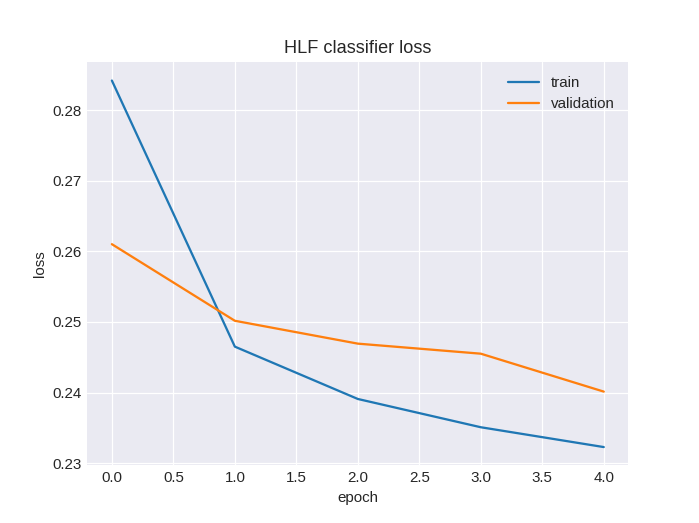

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


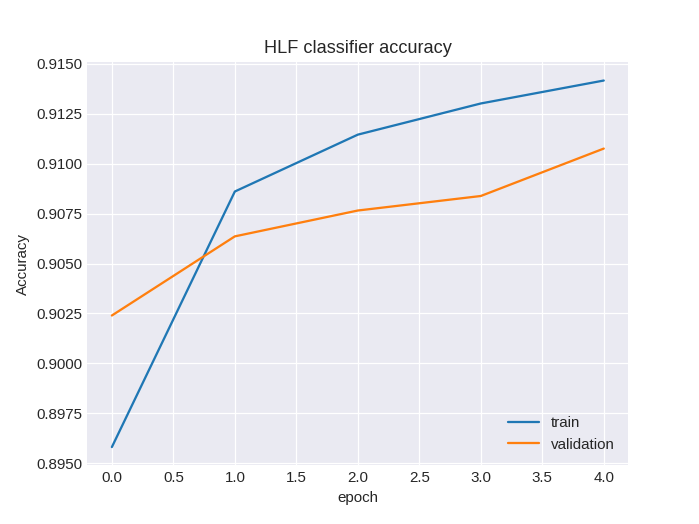

In [10]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [12]:
import numpy as np

# Need to use workers_count=1 to avoid getting data potentially in different order at each execution
with make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False) as test_data:
    y_pred = history.model.predict(test_data)


114/114 [==============================] - 2s 19ms/step


In [13]:
# Need to use workers_count=1 to avoid getting data potentially in different order at each execution
with make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False) as test_data:
    y_true = np.concatenate([labels for features,labels in test_data])

In [14]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9108


<IPython.core.display.Javascript object>


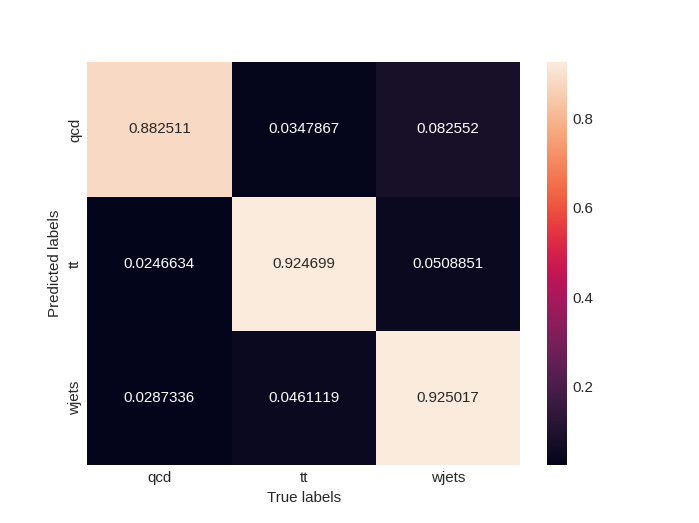

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [16]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [17]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9866373273644378, 1: 0.9850239312017597, 2: 0.9800916583032693}

<IPython.core.display.Javascript object>


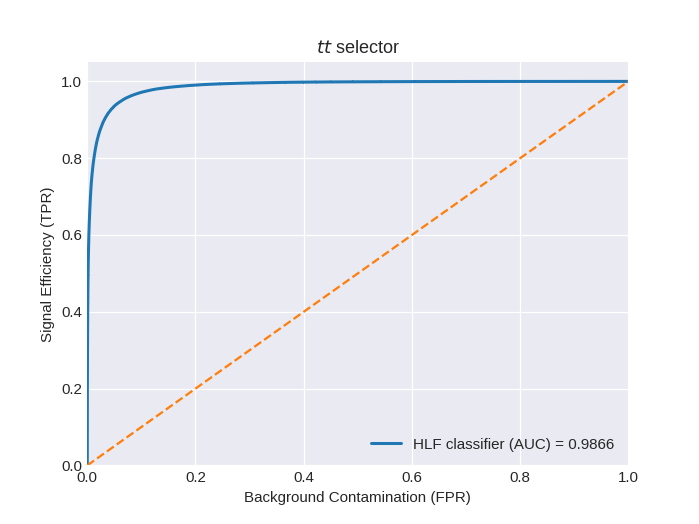

In [18]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()